<a href="https://colab.research.google.com/github/OkanoShogo0903/deep_work_space/blob/master/depth_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#前処理
## GoogleDriveの読み込み
**Please access to b1546842@planet.kanazawa-it.ac.jp**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

work_root = "/content/drive/My Drive/GoogleColab/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd 
import os
from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
from numba import jit
import itertools
from seaborn import countplot,lineplot, barplot
from numba import jit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Conv2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam

import matplotlib.style as style 
style.use('ggplot')

import gc
gc.enable()

pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 230)

!ls
!pwd

Using TensorFlow backend.


drive  sample_data
/content


## データの読み込み

In [0]:
from PIL import Image

# Parameter
image_size = 64

# Load Image
path = work_root + "Training/depth/"
files = os.listdir(path)
files.sort()

#print(files)
X = []

for i, file in enumerate(files):
  if i%100 == 0: # Show progress
    print(round(100*i/len(files)))
  image = Image.open(path + file)
  image = image.convert("L")
  image = image.resize((image_size, image_size)) # 拡大縮小の処理
  data = np.asarray(image) # numpy の np.array と np.asarray は引数が np.ndarray のときにコピーされるかどうかが違う.
  X.append(data)

X = np.array(X)
#X = X.astype('float32')

# Standardization
#X = (X - X.mean()) / X.std()

# Min-Max Normalize
#X = (X - X.min()) / (X.max() - X.min())

#X = X / 255.0

print(X[0].shape)

0
1
1
2
2
3
4
4
5
6
6
7
7
8
9
9
10
11
11
12
12
13
14
14
15
16
16
17
17
18
19
19
20
21
21
22
22
23
24
24
25
26
26
27
27
28
29
29
30
31
31
32
32
33
34
34
35
36
36
37
37
38
39
39
40
41
41
42
42
43
44
44
45
46
46
47
47
48
49
49
50
51
51
52
52
53
54
54
55
56
56
57
57
58
59
59
60
61
61
62
62
63
64
64
65
66
66
67
67
68
69
69
70
71
71
72
72
73
74
74
75
76
76
77
77
78
79
79
80
81
81
82
82
83
84
84
85
86
86
87
87
88
89
89
90
91
91
92
92
93
94
94
95
96
96
97
97
98
99
99
100
(64, 64)


## Preprocess of testdata
raw data have (X pixel, Y pixel, Z mm).  
Author convert to (X mm, Ymm, Z mm) for easier evaluate.

In [0]:
train_raw_data = pd.read_csv(work_root + "Training/Annotation_Training.csv", header=None, skiprows=4, index_col=0)
train_raw_data = np.array(train_raw_data) # convert to numpy from pandas

print(train_raw_data.shape)
#print(raw_data.shape[0], xyz_dim, joint_num)
  
def convert2mm(raw_data):
  # Initialize
  xyz_dim = 3 # mean is x,y,z
  camera = [
      [0.7531, 0, 0],
      [0, 1.004, 0],
      [0, 0, 1]
  ]
  joint_num = int(raw_data.shape[1]/xyz_dim) # 21
  output = np.zeros((raw_data.shape[0], xyz_dim, joint_num), dtype="float") # sum of data number, 3, joint num 63/3

  z_index = range(xyz_dim-1, raw_data.shape[1], xyz_dim) # 3multiple is Z coordinate
  for i, raw in enumerate(raw_data):
    # Extraction.
    z_val = raw[z_index]
    xy_val = np.delete(raw, z_index, axis=None)
    # Reshape.
    one = np.ones((joint_num, 1))
    xy_val = xy_val.reshape(joint_num, 2)
    xy_val = np.hstack((xy_val, one)).T
    xyz_c = np.dot(np.linalg.inv(camera), xy_val) # Shape is (3, 21)
    output[i, :, :] = np.dot(xyz_c, np.diag(z_val))
  return output.reshape(raw_data.shape[0], xyz_dim*joint_num)

print("RAW\n", train_raw_data[:1])
y_train = convert2mm(train_raw_data)
print("Train\n", y_train[:1])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.30)

# Parameter
image_size = 64

X_train = X_train.reshape(X_train.shape[0], image_size, image_size, 1).astype('float32')/255
#X_valid = X_valid.reshape(X_valid.shape[0], image_size, image_size, 1).astype('float32')/255
X_test = X_test.reshape(X_test.shape[0], image_size, image_size, 1).astype('float32')/255

(16008, 63)
RAW
 [[-0.0317083   0.0408649   0.290511   -0.0193339   0.0412509   0.287696
   0.0118844   0.024025    0.275656    0.0388613   0.00222028  0.276134
  -0.0199637  -0.0228997   0.283592   -0.0132386  -0.0532217   0.272818
  -0.00995869 -0.0737945   0.262317   -0.0372012  -0.02187     0.286324
  -0.0419724  -0.0552334   0.279226   -0.0453859  -0.0764059   0.265297
  -0.0548423  -0.0160071   0.289622   -0.0633928  -0.0474526   0.282517
  -0.0684959  -0.06372     0.271108   -0.0696317  -0.00052804  0.290322
  -0.0820007  -0.0271007   0.281751   -0.0901305  -0.0385524   0.274457
   0.0534298  -0.0149134   0.276801   -0.00229264 -0.0913487   0.250513
  -0.0486789  -0.092942    0.250398   -0.0765399  -0.0812963   0.259592
  -0.102182   -0.0512149   0.260291  ]]
Train
 [[-1.22315894e-02 -7.38585273e-03  4.35002811e-03  1.42490057e-02
  -7.51765451e-03 -4.79581513e-03 -3.46877398e-03 -1.41436680e-02
  -1.55620573e-02 -1.59882394e-02 -2.10908732e-02 -2.37810964e-02
  -2.46577964e-02 

## ICVL Hand Posture Dataset
- Each line is corresponding to one image.
- Each line has 16x3 numbers, which indicates (x, y, z) of 16 joint locations. Note that these are joint CENTRE locations.
- Note that (x, y) are in pixels and z is in mm.
- The order of 16 joints is Palm, Thumb root, Thumb mid, Thumb tip, Index root, Index mid, Index tip, Middle root, Middle mid, Middle tip,  Ring root, Ring mid, Ring tip, Pinky root, Pinky mid, Pinky tip.  

https://labicvl.github.io/hand.html


(64, 64)
max 255
min 221
0


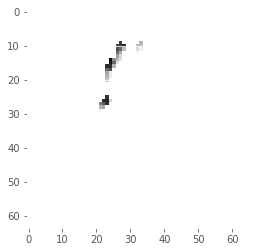

In [0]:
#import cv2 
import matplotlib.pyplot as plt

# グレースケール形式で読み込む。
img = X[1000,:,:]
print(img.shape) 
print("max", img.max())
print("min", img.min())

#print(img.tolist())
print(img.tolist().count(255))

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
plt.show()

print()

In [0]:


#y_train = y_train.reshape(y_train.shape[0], image_size, image_size, 1).astype('float32')/255
#y_test = y_test.reshape(y_test.shape[0], image_size, image_size, 1).astype('float32')/255

# one-hot vector形式に変換する
#y_train = np_utils.to_categorical(y_train, 10)
#y_valid = np_utils.to_categorical(y_valid, 10)
#y_test = np_utils.to_categorical(y_test, 10)

(11205, 64, 64)


## Keras model

In [0]:
model = Sequential()
print(X_train.shape[1:])
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(63))

model.summary()

W0620 03:08:27.998519 140514424342400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 03:08:28.052232 140514424342400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 03:08:28.061856 140514424342400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 03:08:28.135735 140514424342400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0620 03:08:28.143941 140514424342400 deprecation_wrapp

(64, 64, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0        

## Train

In [0]:
optimizers ="Adadelta"
results = {}
epochs = 3
model.compile(loss='mean_squared_error', optimizer=optimizers, metrics=['accuracy'])
print(X_train.shape)
print(y_train.shape)
results= model.fit(X_train, y_train, validation_split=0.2, epochs=epochs )

model_json_str = model.to_json()
open('mnist_mlp_model.json', 'w').write(model_json_str)
model.save_weights('mnist_mlp_weights.h5');

W0620 03:08:28.258795 140514424342400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



(11205, 64, 64, 1)
(11205, 63)


W0620 03:08:28.604748 140514424342400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 8964 samples, validate on 2241 samples
Epoch 1/3
8964/8964 [==============================] - 163s 18ms/step - loss: 0.0107 - acc: 0.1060 - val_loss: 0.0044 - val_acc: 0.2468
Epoch 2/3
8964/8964 [==============================] - 162s 18ms/step - loss: 0.0020 - acc: 0.2286 - val_loss: 0.0011 - val_acc: 0.5069
Epoch 3/3
8964/8964 [==============================] - 161s 18ms/step - loss: 0.0012 - acc: 0.3828 - val_loss: 0.0011 - val_acc: 0.5074


In [0]:
model.save('my_model.h5')
!ls
!cp my_model.h5 drive/My\ Drive/GoogleColab/

drive  mnist_mlp_model.json  mnist_mlp_weights.h5  my_model.h5	sample_data


# Evaluate

In [0]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)

# MESの表示
mse = mean_squared_error(y_test, y_pred)
print("KERAS REG RMSE : %.4f " % (mse ** 0.5))

#loss, acc = model.evaluate(X_test, y_test)
#print("Restored model, accuracy: {:5.2f}%".format(100*acc))

# 各フレームごとに、それぞれの関節における誤差がこの閾値以下であれば正しいとする
acc_thre_mm = 0.1 
corr = 0
for i, j in zip(y_test, y_pred):
  if np.all(i - j <= acc_thre_mm):
    corr += 1
print("CORRECT RATE : ", round(corr/y_pred.shape[0], 4)) # Show correct%
  
print("y_pred\n", y_pred)
print("y_test\n", y_test)

KERAS REG RMSE : 0.0333 
CORRECT RATE :  0.9007
y_pred
 [[-0.00191574  0.00448433  0.01519236 ...  0.30320537  0.308581
   0.31699648]
 [-0.00191574  0.00448433  0.01519236 ...  0.30320537  0.308581
   0.31699648]
 [-0.00191574  0.00448433  0.01519236 ...  0.30320537  0.308581
   0.31699648]
 ...
 [-0.00191574  0.00448433  0.01519236 ...  0.30320537  0.308581
   0.31699648]
 [-0.00191588  0.0044862   0.01519306 ...  0.3032045   0.30857924
   0.31699568]
 [-0.00191574  0.00448433  0.01519236 ...  0.30320537  0.308581
   0.31699648]]
y_test
 [[ 0.00875246  0.01459468  0.02664823 ...  0.260974    0.268018
   0.277471  ]
 [ 0.03797277  0.04173866  0.043703   ...  0.316945    0.325579
   0.30232   ]
 [-0.03131011 -0.02459058 -0.0045486  ...  0.322122    0.324421
   0.422652  ]
 ...
 [ 0.00409403  0.01022136  0.02073177 ...  0.392433    0.367795
   0.379614  ]
 [ 0.0004767   0.00351075  0.00999503 ...  0.30819     0.311248
   0.289871  ]
 [-0.00147066  0.00492786  0.0163446  ...  0.356244   

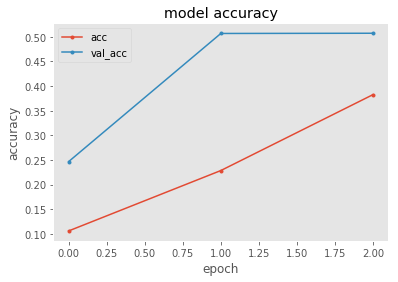

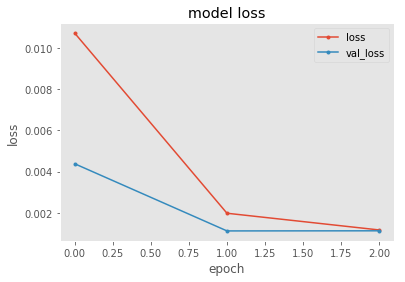

In [0]:
from matplotlib import pyplot as plt

# MSE Plot
plt.plot(results.history['acc'], marker='.', label='acc')
plt.plot(results.history['val_acc'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(results.history['loss'], marker='.', label='loss')
plt.plot(results.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

### 1つのサンプルを可視化
学習データの分散が異様に小さいように見える
深さがほぼ0のデータもあるため、元のデータが何を指していたのかを確認する必要がある.

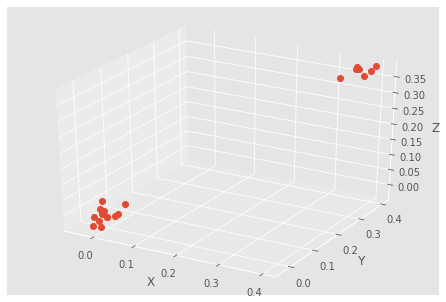

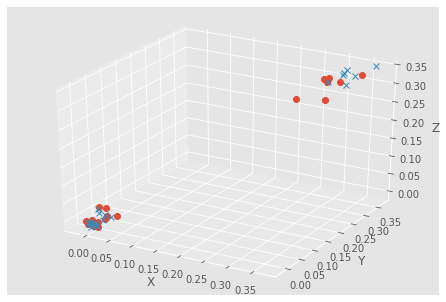

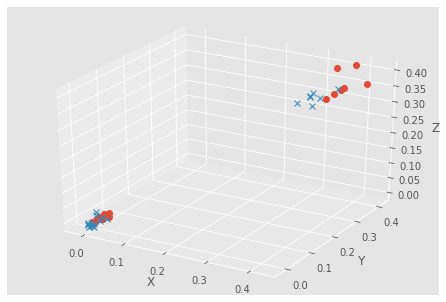

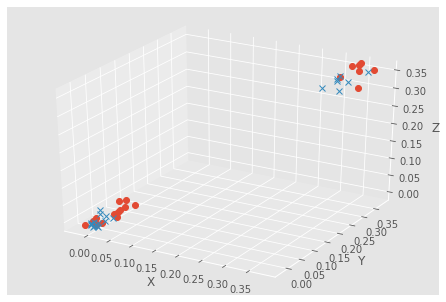

In [0]:
def arrangeMatrix(target, output_index):
  x_index = range(0,63,3)
  x_index = np.array(x_index)
  X = target[output_index, x_index  ].flatten()
  Y = target[output_index, x_index+1].flatten()
  Z = target[output_index, x_index+2].flatten()
  return X,Y,Z


def plot3D(targetA, targetB, output_index):
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")

  #linestyle='None'にしないと初期値では線が引かれるが、3次元の散布図だと大抵ジャマになる
  X, Y, Z = arrangeMatrix(targetA, output_index)
  ax.plot(X,Y,Z,marker="o",linestyle='None')
  if type(targetB) != type(None):
    X, Y, Z = arrangeMatrix(targetB, output_index)
    ax.plot(X,Y,Z,marker="x",linestyle='None')
  plt.show()


plot3D(y_train, None, 0)

plot3D(y_test, y_pred, 0)
plot3D(y_test, y_pred, 1000)
plot3D(y_test, y_pred, 2000)

